# CASE STUDY: AB TESTING

A. Requirement: Increasing CR through Landing Page  
  
B. Objective: The primary goal of the A/B test is to determine whether the new landing page design (treatment group) results in a higher conversion rate than the current design (control group). By identifying the most effective landing page design, the company hopes to optimize its product pages and increase overall conversion rates, which will boost sales and revenue.  
  
D. Case Study Questions:  
    1. Which landing page design (treatment or control) generated a higher conversion rate during the A/B test?  
    2. Is the variation in conversion rates between the two landing page designs statistically significant?  
  
E. Methodology:  
    1. Experiment Design:  
        (1) Simulating & Plotting Normal Distribution  
        (2) Hypothesis Setting  
        (3) Power Analysis  
        (4) Sample Size Estimation  
    2. Data Cleaning & Exploratory Analysis  
        (1) Missing Value  
        (2) Duplicate  
        (3) EDA Summary Stats  
    3. Internal Validity  
        (1) Sample Ratio Mismatch (SRM) - Chi Square  
    4. Analyzing differences in proportion A/B Testing  
        (1) Sample Proportion Z-Test   
    5. Analyzing differences in means A/B Testing  
        (1) Bootstrap Analysis  

In [2]:
# Import packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Lodd dataset into pandas
AB = pd.read_csv('ab_data.csv')

In [4]:
# Biefing the data columns
AB.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [5]:
AB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


# 1 Experiment Design

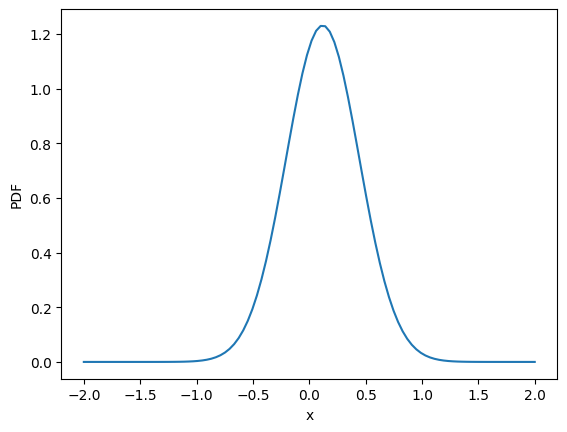

In [6]:
# Simulating & Plotting Normal Distribution 
from scipy.stats import norm

# Plot a normal distribution
mean = 0.119
sd = 0.324

x = np.linspace(-2, 2, 100)
norm_a = norm.pdf(x,mean,sd)

sns.lineplot(x=x,y=norm_a)
plt.xlabel('x')
plt.ylabel('PDF')
plt.show()

In [7]:
# Hypothesis Setting  
# H0: There is no difference in conversion rates between the two landing page designs. (μ0=μ1)
# H1: There is a difference in conversion rates between the two landing page designs. (μ0≠μ1)

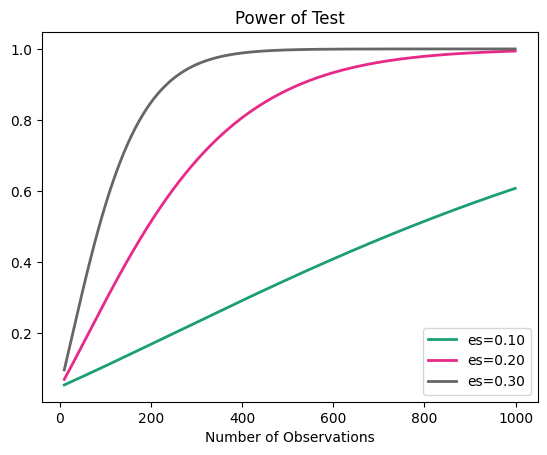

In [8]:
# Power Analysis  
from statsmodels.stats.power import TTestIndPower

# Specify parameters for power analysis
sample_sizes = np.array(range(10,1000))
effect_sizes = np.array([0.1,0.2,0.3])

# Plot power curves
TTestIndPower().plot_power(nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

Assumption: We only have data of Old Page -> Now we need to consider our sample size

In [9]:
# Sample Size Estimation  -
# Calculate and print the baseline mean and standard deviation of old Page
mean_Old = AB[AB['landing_page']=='old_page']['converted'].mean()
print(mean_Old)

std_Old = AB[AB['landing_page']=='old_page']['converted'].std()
print(std_Old)


0.12047759085568362
0.3255202921894224


We expected new mean will be 0.186 --> We set this number because we want to set the effect size is Small (=0.2)

In [10]:
# Define mean_new and calculate the standardized effect size
mean_New = 0.186

std_effect_size = (mean_New - mean_Old) / std_Old
print(std_effect_size)

0.20128517550662697


Assumption:
- Power = .80
- Alpha = .05

In [11]:
# Calculate the required sample size
from statsmodels.stats.power import TTestIndPower

sample_size = TTestIndPower().solve_power(effect_size=std_effect_size, power=0.80, alpha=0.05, nobs1=None)

print(sample_size)

388.41035110748555


# 2 Data Cleaning & Exploratory Analysis  

In [12]:
# Missing Value 
missing_values = AB.isnull().sum()
print(missing_values)

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


In [13]:
# Duplicate  
AB.drop_duplicates( subset = 'user_id', keep = 'first', inplace = True)

AB.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

In [14]:
# EDA Summary Stats
suma = AB.groupby('landing_page')['converted'].agg({'mean','std','max','min','count','sem'})
suma.columns = ['Conversion_Rate', 'Standard_Deviation','Max_CR','Min_CR','Count','Std_Error']
suma.style.format('{:.3f}')

,Conversion_Rate,Standard_Deviation,Max_CR,Min_CR,Count,Std_Error
landing_page,,,,,,
new_page,1.000,0.000,145320.000,0.001,0.323,0.119
old_page,1.000,0.000,145264.000,0.001,0.325,0.120


As a result, we can assume that there might not be a significant difference between the two groups.

# 3 Internal Validity  

In [15]:
# Sample Ratio Mismatch (SRM) - Chi Square  
# Assign the unqiue counts to each variant
control_users = AB[AB['landing_page'] == 'old_page']['user_id'].nunique()
treatment_users = AB[AB['landing_page'] == 'new_page']['user_id'].nunique()
total_users = control_users + treatment_users
print("Control unique users:",control_users)
print("Control unique users:",treatment_users)

# Calculate the percentages and create two lists
control_perc = control_users / total_users
treatment_perc = treatment_users / total_users
print("Percentage of users in the Control group:",100*round(control_perc,5),"%")
print("Percentage of users in the Exposed group:",100*round(treatment_perc,5),"%")

observed = [ control_users, treatment_users ]
expected = [ total_users/2, total_users/2 ]

# Run chisquare test on observed and expected lists and print the results
from scipy.stats import chisquare
chi = chisquare(observed, f_exp=expected)

print(chi)
if chi[1] < 0.01:
    print("SRM may be present")
else:
    print("SRM likely not present")

Control unique users: 145264
Control unique users: 145320
Percentage of users in the Control group: 49.99 %
Percentage of users in the Exposed group: 50.01 %
Power_divergenceResult(statistic=0.010792060127192138, pvalue=0.9172607373796061)
SRM likely not present


# 4 Analyzing differences in proportion A/B Testing  

In [16]:
# Sample Proportion Z-Test 
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import statsmodels.stats.api as sms

# Calculate the number of users in groups C and D
n_Old = AB[AB['landing_page'] == 'old_page']['user_id'].nunique()
n_New = AB[AB['landing_page'] == 'new_page']['user_id'].nunique()
print('Group Old users:',n_Old)
print('Group New users:',n_New)

# Compute unique signups in each group and assign to lists
CR_Old = AB[AB['landing_page'] == 'old_page'].groupby('user_id')['converted'].max().sum()
CR_New = AB[AB['landing_page'] == 'new_page'].groupby('user_id')['converted'].max().sum()

cr_abtest = [CR_Old, CR_New]
n_cdtest = [n_Old, n_New]

# Calculate the z_stat, p-value, and 95% confidence intervals
z_stat, pvalue = proportions_ztest(cr_abtest, nobs=n_cdtest)
(old_lo95, new_lo95), (old_up95, new_up95) = proportion_confint(cr_abtest, nobs=n_cdtest, alpha=0.05)

print(f'Test Stat: {z_stat:.4f}')
print(f'p-value: {pvalue:.4f}')
print(f'Group Old 95% CI : [{old_lo95:.4f}, {old_up95:.4f}]')
print(f'Group New 95% CI : [{new_lo95:.4f}, {new_up95:.4f}]')

Group Old users: 145264
Group New users: 145320
Test Stat: 1.3705
p-value: 0.1705
Group Old 95% CI : [0.1187, 0.1221]
Group New 95% CI : [0.1171, 0.1204]


# Analyzing differences in means A/B Testing  

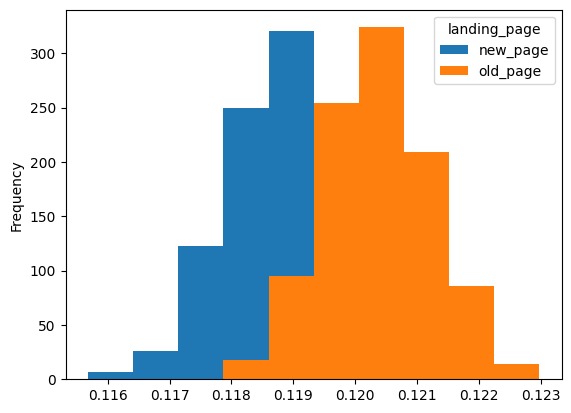

In [17]:
# Bootstrap Analysis
AB_CR_mean = round(AB.groupby('landing_page')['converted'].mean()*100,2)

# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = AB.sample(frac=1,replace=True).groupby('landing_page')['converted'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_1d
# A Kernel Density Estimate plot of the bootstrap distributions
ax = boot_1d.plot(kind='hist')

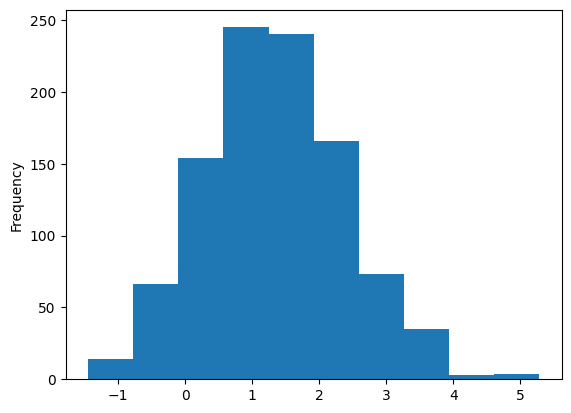

In [18]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['old_page'] - boot_1d['new_page'])/boot_1d['new_page']*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='hist')

In [19]:
# Calculating the probability that old_page is greater than new_page (mean)
prob = (boot_1d['diff']>0).mean()
print(round(prob,3))

0.897


# SUMMARY

The calculated p-value from the hypothesis test is 0.1705, which is greater than the significance level (0.05). As a result, we were unable to reject the null hypothesis. The statistical test yielded insufficient evidence to conclude that there is a significant difference in conversion rates between the two landing page designs. In other words, the observed difference in conversion rates could be due to random variation rather than a genuine effect of the design change.

While the A/B test results showed no statistically significant difference in conversion rates, the small difference suggests that both landing page designs convert users similarly. Because the new landing page design does not significantly improve conversion rates, it is recommended that you keep the current landing page design or consider iterating and testing new designs to achieve a meaningful improvement in conversion rates.